## T>C 変換率の計算

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# color-blind safe color scheme from https://personal.sron.nl/~pault/#fig:scheme_bright
blue, cyan, green, yellow = "#4477AA", "#66CCEE", "#228833", "#CCBB44"
red, purple, grey, black = "#EE6677", "#AA3377", "#BBBBBB", "#333333"

サンプルIDの読み込み

In [2]:
with open("../slamdunk/SRR_Acc_List.txt", "r") as f:
    sampleID = f.read().splitlines()
    print(sampleID)

['DRR438599', 'DRR438600', 'DRR438601', 'DRR438602', 'DRR438603', 'DRR438604', 'DRR438605', 'DRR438606', 'DRR438607', 'DRR438608', 'DRR438609', 'DRR438610', 'DRR438611', 'DRR438612', 'DRR438613', 'DRR438614', 'DRR438615', 'DRR438616']


In [3]:
path = f"../slamdunk/utrrates/{sampleID[0]}/{sampleID[0]}_1.fastq_slamdunk_mapped_filtered_mutationrates_utr.csv"
print(path)

df =  pd.read_csv(path, sep="\t", index_col=["Name", "Chr", "Start", "End"], skiprows=2)
df.head()

../slamdunk/utrrates/DRR438599/DRR438599_1.fastq_slamdunk_mapped_filtered_mutationrates_utr.csv


,,,,Strand,ReadCount,A_A,A_C,A_G,A_T,A_N,C_A,C_C,C_G,...,T_A,T_C,T_G,T_T,T_N,N_A,N_C,N_G,N_T,N_N
Name,Chr,Start,End,,,,,,,,,,,,,,,,,,,,,
OR4F5|ENSG00000186092.7,chr1,70009,71585,+,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11|ENSG00000187634.13,chr1,944154,944574,+,1626,41592,2,7,4,0,70,59817,11,...,509,968,10,36971,0,0,0,0,0,0
NOC2L|ENSG00000188976.11,chr1,944203,944693,-,1354,52365,15,457,13,0,2,29457,1,...,0,1126,0,37467,0,0,0,0,0,0
KLHL17|ENSG00000187961.15,chr1,965192,965719,+,94,2166,0,2,0,0,0,2874,0,...,2,103,24,2539,0,0,0,0,0,0
PLEKHN1|ENSG00000187583.11,chr1,974576,975865,+,11,687,0,0,0,0,0,179,0,...,0,0,0,86,0,0,0,0,0,0


CSV ファイルのヘッダー (2行目) には各変換率 (e.g., T>C, G>A, A>A etc.) の中央値が記載されている。このファイルの場合は以下の通り。</br>
Median-Conversions= 
- A>T:0.0	A>G:0.018843392564397293	A>C:0.0	
- C>A:0.0	C>G:0.0	C>T:0.055663790704146954	
- G>A:0.08635578583765112	G>C:0.0	G>T:0.0	
- T>A:0.04877097151775263	T>G:0.015617679212868968	T>C:2.69821502698215

`SLAM-DUNK` のソースコード (https://github.com/t-neumann/slamdunk/blob/cf9bbbdebcb86ca1cc0c60aa9ea268deb565cd25/slamdunk/dunks/stats.py#L331) にかかれている方法で T>C 変換率を計算してみる。

各塩基対の変換効率を計算し pd.Series として返す関数 `calculate_conversion()` を作成。相補鎖については T>C 変換率ではなく A>G 変換率を求める。

In [4]:
def calculate_conversion(df):
    
    # 各塩基の合計Nsumを求める
    Asum = df["A_A"] + df["A_C"] + df["A_G"] + df["A_T"]
    Csum = df["C_A"] + df["C_C"] + df["C_G"] + df["C_T"]
    Gsum = df["G_A"] + df["G_C"] + df["G_G"] + df["G_T"]
    Tsum = df["T_A"] + df["T_C"] + df["T_G"] + df["T_T"]
    
    # Nsumが1以上であれば変換率を計算, そうでなければ0を代入
    if Asum > 0:
        A_T = df["A_T"] / Asum * 100
        A_G = df["A_G"] / Asum * 100
        A_C = df["A_C"] / Asum * 100
    else:
        A_T = A_G = A_C = 0
        
    if Csum > 0:
        C_A = df["C_A"] / Csum * 100
        C_G = df["C_G"] / Csum * 100
        C_T = df["C_T"] / Csum * 100
    else:
        C_A = C_G = C_T = 0   
        
    if Gsum > 0:
        G_T = df["G_T"] / Gsum * 100
        G_A = df["G_A"] / Gsum * 100
        G_C = df["G_T"] / Gsum * 100
    else:
        G_T = G_A = G_C = 0
        
    if Tsum > 0:
        T_A = df["T_A"] / Tsum * 100
        T_G = df["T_G"] / Tsum * 100
        T_C = df["T_C"] / Tsum * 100
    else:
        T_A = T_G = T_C = 0
        
    # T>C または T>A の絶対数
    TCsum = df["T_C"]
    AGsum = df["A_G"]
    TAsum = df["T_A"]
    ATsum = df["A_T"]
    
    # 遺伝子がマイナス鎖の場合は相補塩基に変換
    if df["Strand"] == "-":
        A_C, T_G = T_G, A_C
        A_G, T_C = T_C, A_G
        A_T, T_A = T_A, A_T
        C_A, G_T = G_T, C_A
        C_G, G_C = G_C, C_G
        C_T, G_A = G_A, C_T
        Asum, Tsum = Tsum, Asum
        TCsum, TAsum = AGsum, ATsum
        
    return pd.Series([A_C, A_G, A_T, C_A, C_G, C_T, G_A, G_C, G_T, T_A, T_C, T_G, TCsum, TAsum, Tsum])

'DRR438599' について計算してみる。

In [5]:
df =  pd.read_csv(path, sep="\t", index_col=["Name", "Chr", "Start", "End"], skiprows=2)

df = df[df["ReadCount"] > 0]

# データフレームに出力する数値 (※ 関数が return する順番と一致させる)
conversions = ["A>C", "A>G", "A>T", "C>A", "C>G", "C>T", "G>A", "G>C", "G>T", "T>A", "T>C", "T>G", "T_C", "T_A", "Tsum"]

df[conversions] = df.apply(calculate_conversion, axis=1)
df = df[conversions]

df.head()

,,,,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,T_C,T_A,Tsum
Name,Chr,Start,End,,,,,,,,,,,,,,,
SAMD11|ENSG00000187634.13,chr1,944154,944574,0.004807,0.016825,0.009614,0.116764,0.018349,0.086739,0.580808,0.002104,0.002104,1.323522,2.517032,0.026002,968.0,509.0,38458.0
NOC2L|ENSG00000188976.11,chr1,944203,944693,0.000000,2.917628,0.000000,0.000000,0.000000,3.700876,0.016969,0.003394,0.006788,0.024598,0.864711,0.028382,457.0,13.0,52850.0
KLHL17|ENSG00000187961.15,chr1,965192,965719,0.000000,0.092251,0.000000,0.000000,0.000000,0.138985,0.000000,0.000000,0.000000,0.074963,3.860570,0.899550,103.0,2.0,2668.0
PLEKHN1|ENSG00000187583.11,chr1,974576,975865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.157895,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,86.0
HES4|ENSG00000188290.11,chr1,998964,999058,0.005162,0.020648,0.005162,0.000000,0.000000,0.087968,0.043796,0.000000,0.000000,0.013327,1.252777,0.031097,282.0,3.0,22510.0


In [6]:
df["T>C"].median()

2.69821502698215

マイナス鎖の遺伝子を相補的にしてやるのと (T>C → A>G) リードカウントが1以上の遺伝子を計算に入れることで T>C:2.69821502698215 を再現できた！

### utrrates が出力する図の再現

T>C median: 2.69821502698215


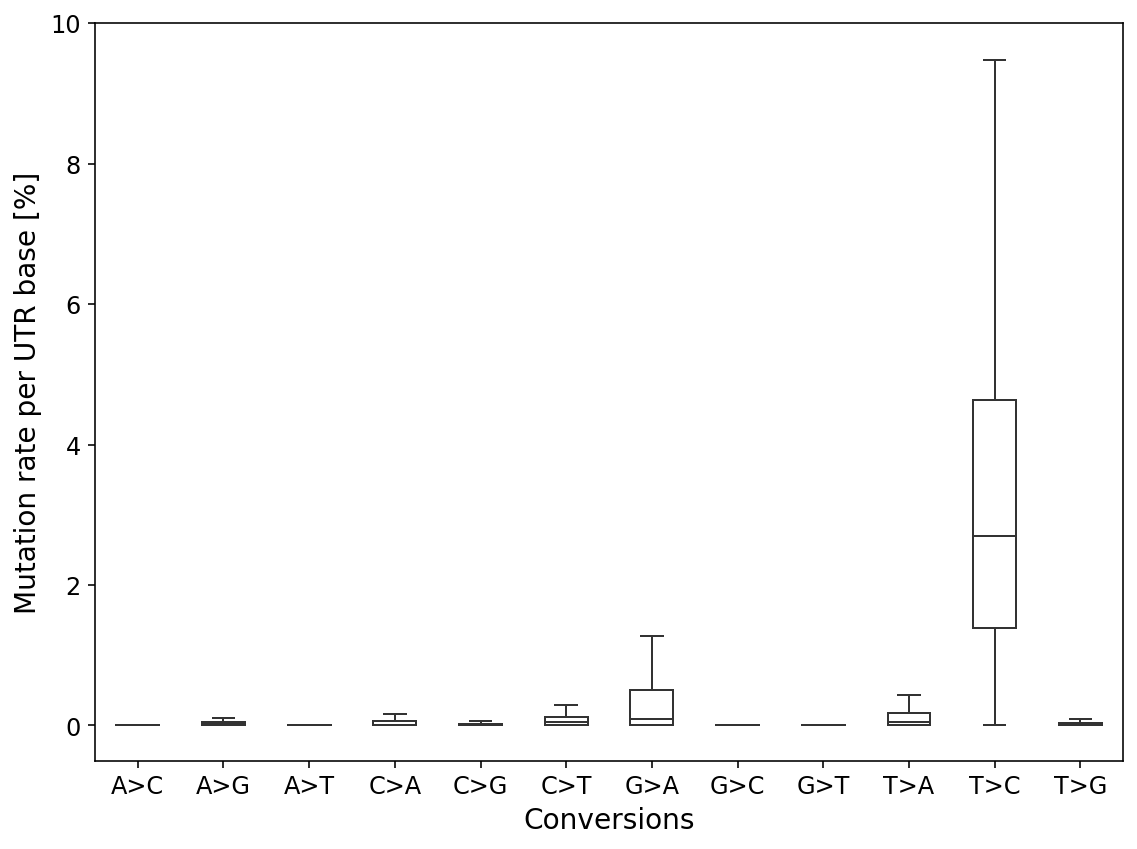

In [7]:
AC, AG, AT = df["A>C"], df["A>G"], df["A>T"]
CA, CG, CT = df["C>A"], df["C>G"], df["C>T"]
GA, GC, GT = df["G>A"], df["G>C"], df["G>T"]
TA, TC, TG = df["T>A"], df["T>C"], df["T>G"]

fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax = fig.add_subplot(1, 1, 1)

ax.tick_params(direction="out", labelsize=12)
ax.set_ylabel("Mutation rate per UTR base [%]", fontsize=14)
ax.set_xlabel("Conversions", fontsize=14)
ax.set_ylim(-0.5, 10)

labels = ["A>C", "A>G", "A>T", "C>A", "C>G", "C>T", "G>A", "G>C", "G>T", "T>A", "T>C", "T>G"]

ax.boxplot([AC, AG, AT, CA, CG, CT, GA, GC, GT, TA, TC, TG], labels=labels, 
                    sym="",                                                                                                                 # 外れ値を表示しない
                    patch_artist=True,                                                                                              # 細かい設定をするモード
                    boxprops=dict(facecolor="white", color=black, linewidth=1),                      # boxの枠線の設定
                    medianprops=dict(color=black, linewidth=1),                                                 # 中央値の線の設定
                    whiskerprops=dict(color=black, linewidth=1),                                                # ヒゲの線の設定
                    capprops=dict(color=black, linewidth=1)                                                        # ヒゲの先端の線の設定
                    );
    
median = df["T>C"].median()
print(f"T>C median: {median}")
# fig.savefig("../figure_4/MAplot_All.pdf", bbox_inches="tight", transparent=True)

`SLAM-DUNK` が出力する変換率の図を完全に再現することができた。論文用に図を作る。

T>C median: 2.698
T>C median: 2.317
T>C median: 2.391
T>C median: 2.405
T>C median: 2.488
T>C median: 2.481
T>C median: 2.224
T>C median: 2.272
T>C median: 2.085


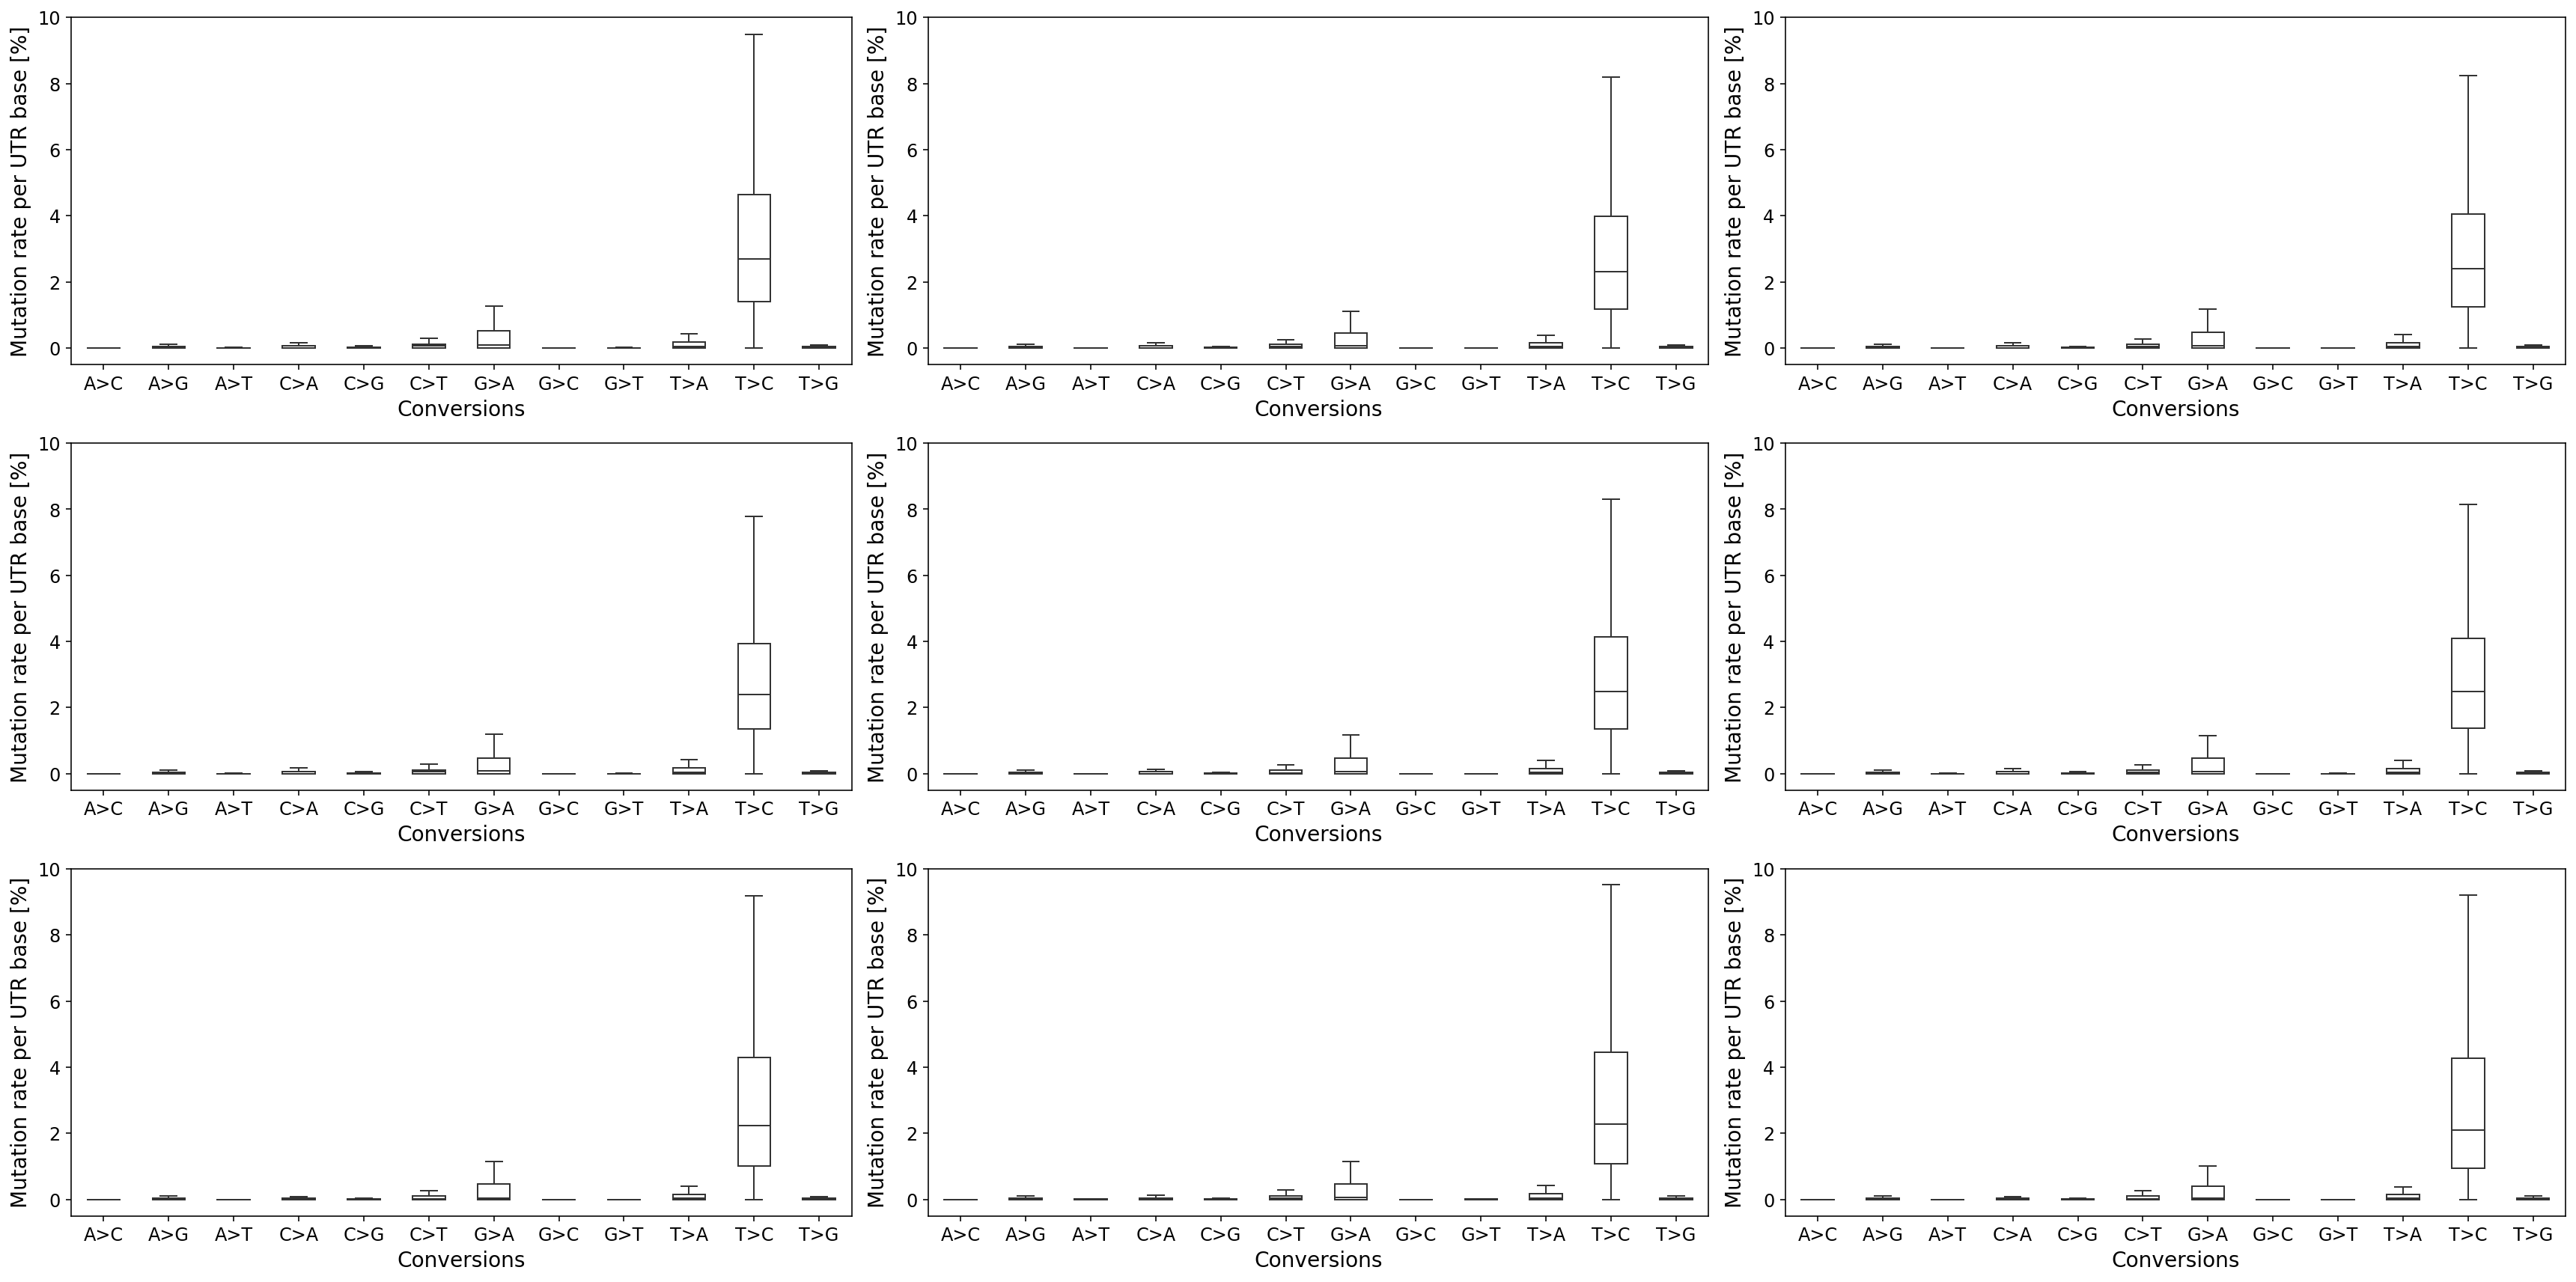

In [8]:
labels = ["A>C", "A>G", "A>T", "C>A", "C>G", "C>T", "G>A", "G>C", "G>T", "T>A", "T>C", "T>G"]

fig = plt.figure(figsize=(24, 12), tight_layout=True)
ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)
ax6 = fig.add_subplot(3, 3, 6)
ax7 = fig.add_subplot(3, 3, 7)
ax8 = fig.add_subplot(3, 3, 8)
ax9 = fig.add_subplot(3, 3, 9)

for ID, ax in zip((sampleID[0:9]), (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9)):
    path = f"../slamdunk/utrrates/{ID}/{ID}_1.fastq_slamdunk_mapped_filtered_mutationrates_utr.csv"
    
    df =  pd.read_csv(path, sep="\t", index_col=["Name", "Chr", "Start", "End"], skiprows=2)
    df[conversions] = df.apply(calculate_conversion, axis=1)
    
    df=df[df["ReadCount"] > 0]
    AC, AG, AT = df["A>C"], df["A>G"], df["A>T"]
    CA, CG, CT = df["C>A"], df["C>G"], df["C>T"]
    GA, GC, GT = df["G>A"], df["G>C"], df["G>T"]
    TA, TC, TG = df["T>A"], df["T>C"], df["T>G"]
    
    ax.tick_params(direction="out", labelsize=12)
    ax.set_ylabel("Mutation rate per UTR base [%]", fontsize=14)
    ax.set_xlabel("Conversions", fontsize=14)
    ax.set_ylim(-0.5, 10)
    
    ax.boxplot([AC, AG, AT, CA, CG, CT, GA, GC, GT, TA, TC, TG], labels=labels, 
                    sym="",                                                                                                                 # 外れ値を表示しない
                    patch_artist=True,                                                                                              # 細かい設定をするモード
                    boxprops=dict(facecolor="white", color=black, linewidth=1),                      # boxの枠線の設定
                    medianprops=dict(color=black, linewidth=1),                                                 # 中央値の線の設定
                    whiskerprops=dict(color=black, linewidth=1),                                                # ヒゲの線の設定
                    capprops=dict(color=black, linewidth=1)                                                        # ヒゲの先端の線の設定
                    );
    
    median = round(df["T>C"].median(), 3)
    print(f"T>C median: {median}")
    
fig.savefig("../results/figure_S4/BoxPlot_Conversions_1.pdf", bbox_inches="tight", transparent=True)

T>C median: 2.004
T>C median: 1.949
T>C median: 1.85
T>C median: 2.301
T>C median: 2.343
T>C median: 2.302
T>C median: 1.955
T>C median: 2.07
T>C median: 2.086


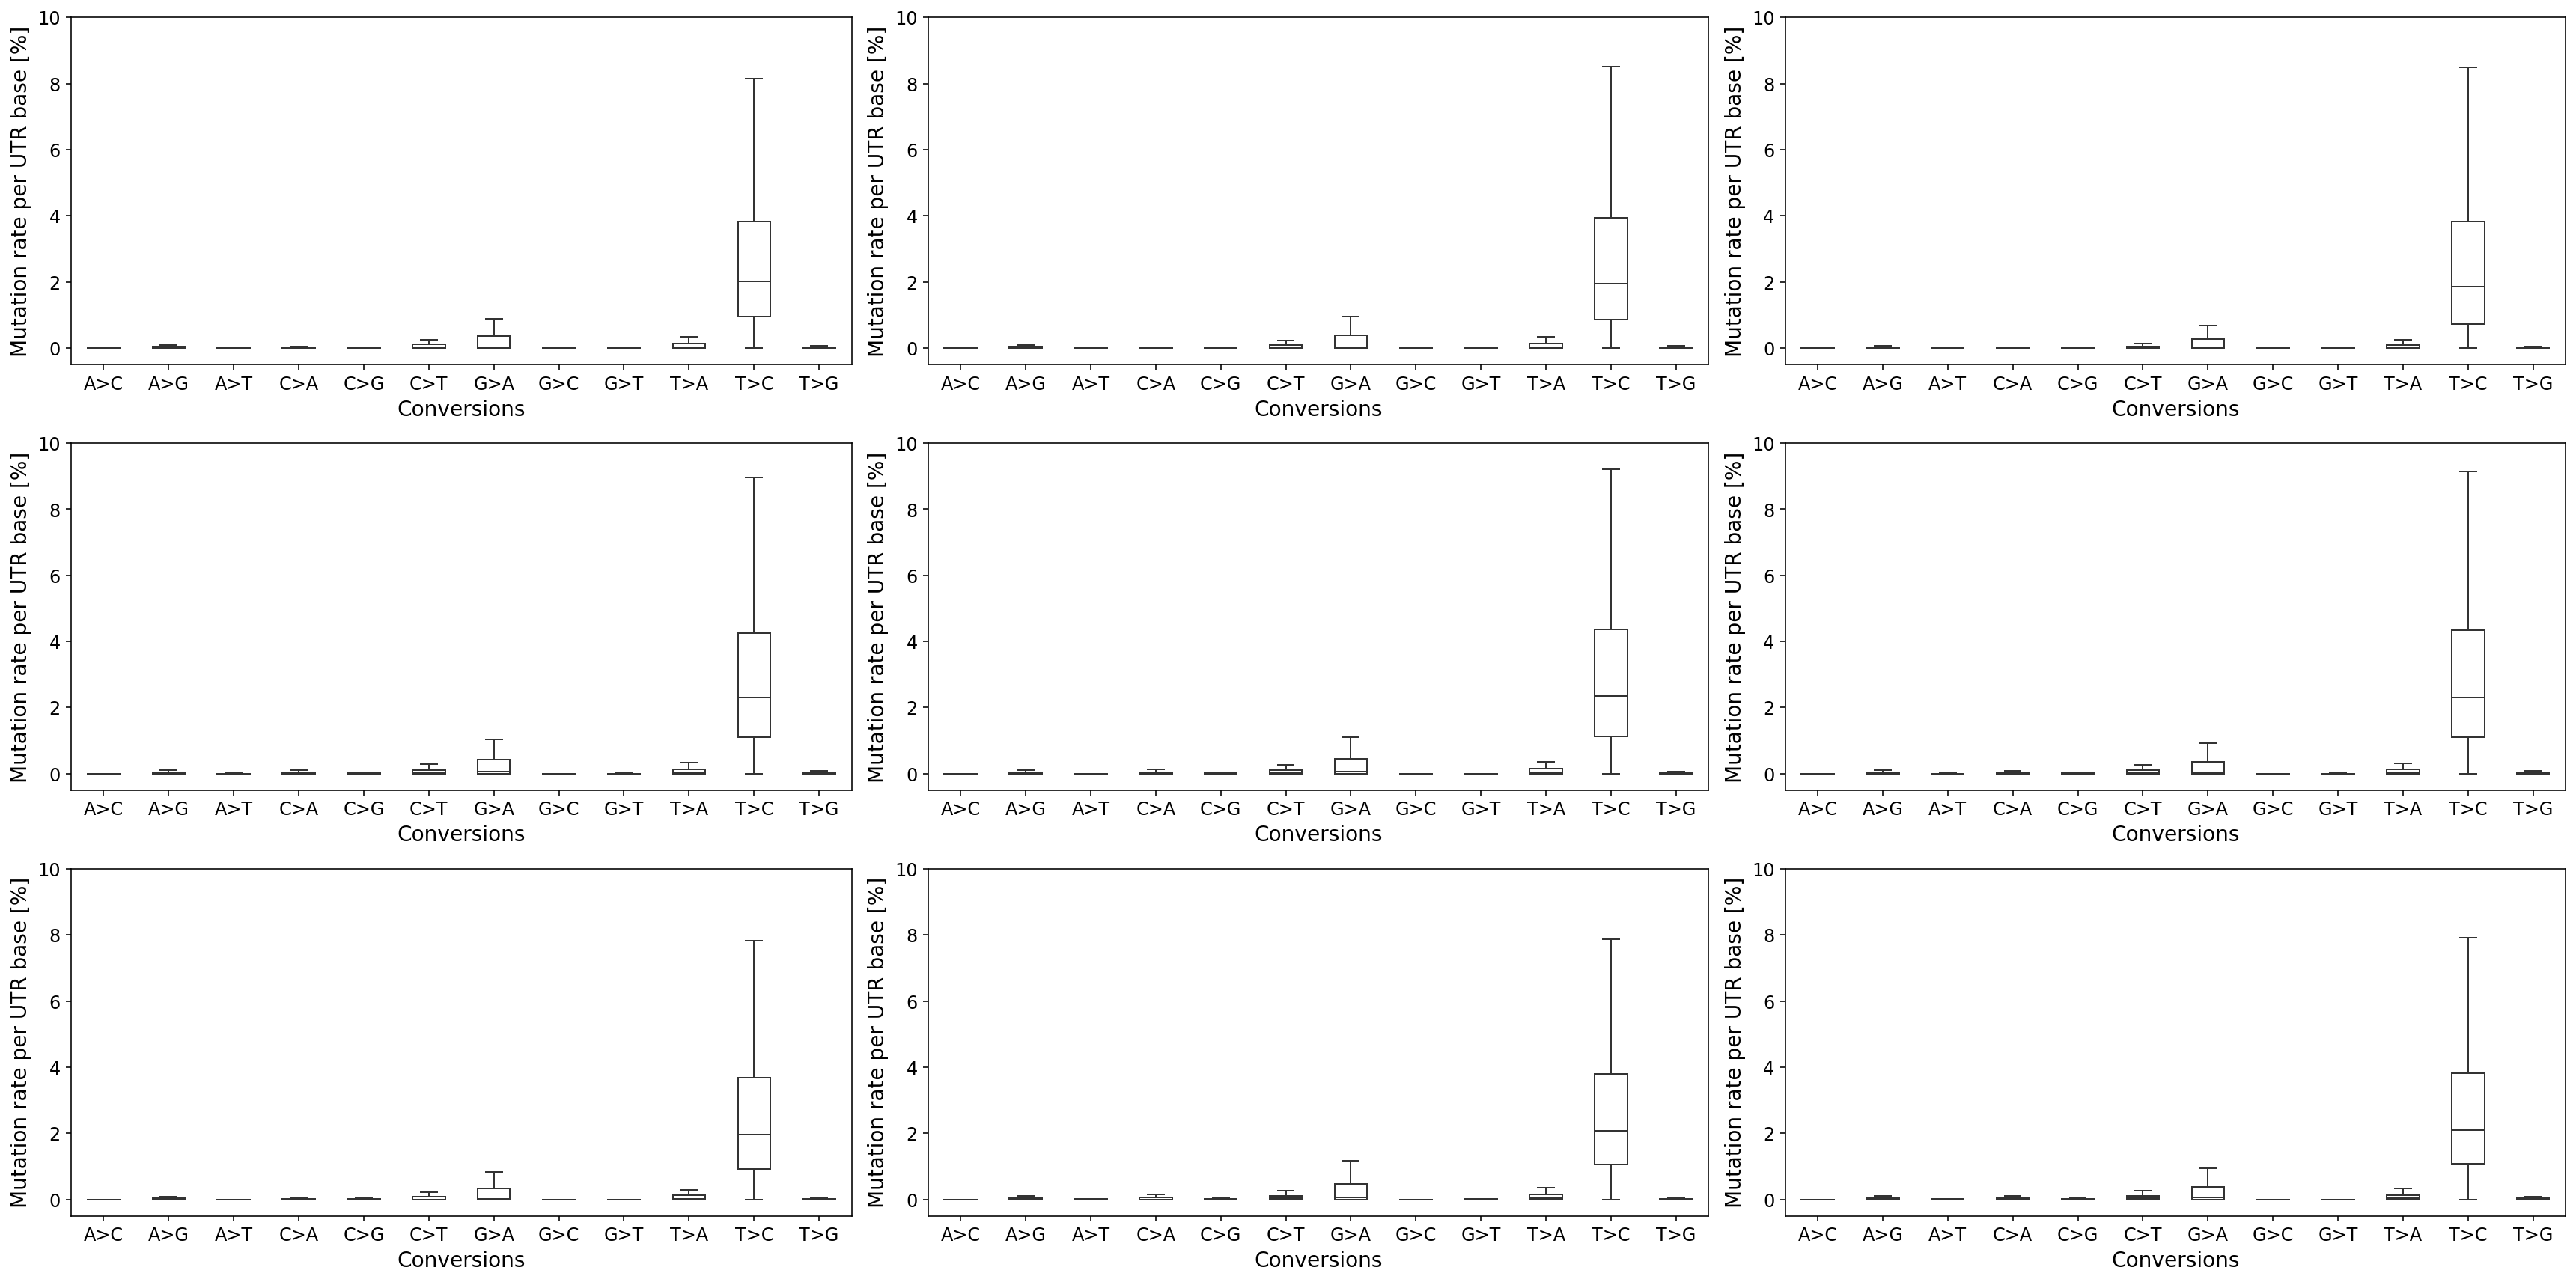

In [9]:
labels = ["A>C", "A>G", "A>T", "C>A", "C>G", "C>T", "G>A", "G>C", "G>T", "T>A", "T>C", "T>G"]

fig = plt.figure(figsize=(24, 12), tight_layout=True)
ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)
ax6 = fig.add_subplot(3, 3, 6)
ax7 = fig.add_subplot(3, 3, 7)
ax8 = fig.add_subplot(3, 3, 8)
ax9 = fig.add_subplot(3, 3, 9)

for ID, ax in zip((sampleID[9:18]), (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9)):
    path = f"../slamdunk/utrrates/{ID}/{ID}_1.fastq_slamdunk_mapped_filtered_mutationrates_utr.csv"
    
    df =  pd.read_csv(path, sep="\t", index_col=["Name", "Chr", "Start", "End"], skiprows=2)
    df[conversions] = df.apply(calculate_conversion, axis=1)
    
    df=df[df["ReadCount"] > 0]
    AC, AG, AT = df["A>C"], df["A>G"], df["A>T"]
    CA, CG, CT = df["C>A"], df["C>G"], df["C>T"]
    GA, GC, GT = df["G>A"], df["G>C"], df["G>T"]
    TA, TC, TG = df["T>A"], df["T>C"], df["T>G"]
    
    ax.tick_params(direction="out", labelsize=12)
    ax.set_ylabel("Mutation rate per UTR base [%]", fontsize=14)
    ax.set_xlabel("Conversions", fontsize=14)
    ax.set_ylim(-0.5, 10)
    
    ax.boxplot([AC, AG, AT, CA, CG, CT, GA, GC, GT, TA, TC, TG], labels=labels, 
                    sym="",                                                                                                                 # 外れ値を表示しない
                    patch_artist=True,                                                                                              # 細かい設定をするモード
                    boxprops=dict(facecolor="white", color=black, linewidth=1),                      # boxの枠線の設定
                    medianprops=dict(color=black, linewidth=1),                                                 # 中央値の線の設定
                    whiskerprops=dict(color=black, linewidth=1),                                                # ヒゲの線の設定
                    capprops=dict(color=black, linewidth=1)                                                        # ヒゲの先端の線の設定
                    );
    
    median = round(df["T>C"].median(), 3)
    print(f"T>C median: {median}")
    
fig.savefig("../results/figure_S4/BoxPlot_Conversions_2.pdf", bbox_inches="tight", transparent=True)